In [1]:
import laspy
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import numpy as np
from sklearn.preprocessing import StandardScaler

Read laz file, assign to pandas DataFrame

In [2]:
las_file = laspy.read("data/SaintLouisLiDAR.laz")

features_of_las = list(las_file.point_format.dimension_names)
features_of_las

['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'nir']

In [3]:
# Access scale and offset values of x,y,z
scale_x = las_file.header.scale[0]
offset_x = las_file.header.offset[0]
scale_y = las_file.header.scale[1]
offset_y = las_file.header.offset[1]
scale_z = las_file.header.scale[2]
offset_z = las_file.header.offset[2]

data = {
    # "X": las_file.X * scale_x + offset_x,
    # "Y": las_file.Y * scale_y + offset_y,
    # "Z": las_file.Z * scale_z + offset_z,
    "X": las_file.X,
    "Y": las_file.Y,
    "Z": las_file.Z,
    "intensity": las_file.intensity,
    "return_number": np.asarray(las_file.return_number),
    "number_of_returns": np.asarray(las_file.number_of_returns),
    "red": las_file.red,
    "green": las_file.green,
    "blue": las_file.blue
}
df = pd.DataFrame(data)
df.isnull().sum()

X                    0
Y                    0
Z                    0
intensity            0
return_number        0
number_of_returns    0
red                  0
green                0
blue                 0
dtype: int64

In [4]:
len_data = len(las_file.points)
len_data

9236517

In [5]:
df.head()

,X,Y,Z,intensity,return_number,number_of_returns,red,green,blue
0,911303,275080,160166,12592,2,2,17664,23296,17920
1,911981,275055,160212,12944,3,3,15872,22016,15872
2,912662,275031,160258,10848,3,3,18432,25344,17408
3,913355,275006,160283,8240,3,3,17920,24064,17920
4,914036,274981,160313,15968,1,1,17408,22528,18432


In [6]:
df.tail()

,X,Y,Z,intensity,return_number,number_of_returns,red,green,blue
9236512,2357675,1739671,196410,17072,1,1,46592,41984,37632
9236513,2357281,1739659,196430,19600,1,1,46592,41984,37376
9236514,2356901,1739582,196449,19648,1,1,46592,41984,37376
9236515,2356525,1739506,196475,19472,1,1,46592,41984,37376
9236516,2356162,1739433,196480,20768,1,1,46592,41984,37376


In [7]:
las_min_x, las_max_x = df["X"].min(), df["X"].max()
las_min_y, las_max_y = df["Y"].min(), df["Y"].max()

print("min and max values of points in las file")
print(f"Min X: {las_min_x}, Max X: {las_max_x}, range: {(las_max_x - las_min_x)}")
print(f"Min Y: {las_min_y}, Max Y: {las_max_y}, range: {las_max_y - las_min_y}")

min and max values of points in las file
Min X: 885001, Max X: 2385000, range: 1499999
Min Y: 246001, Max Y: 1745999, range: 1499998


In [8]:
shape_file = gpd.read_file("data/SaintLouisTrees/SaintLouisTrees.shp")
# Swap the positions of the last and first polygons to speed up label
first_polygon = shape_file.iloc[0]
last_polygon = shape_file.iloc[-1]

shape_file.iloc[0] = last_polygon
shape_file.iloc[-1] = first_polygon
shape_file.shape

(22, 2)

In [9]:
shape_file.head()

,id,geometry
0,0,"POLYGON ((731159.602 4302746.329, 731164.993 4..."
1,0,"POLYGON ((731285.335 4302721.912, 731280.896 4..."
2,0,"POLYGON ((731193.691 4302745.378, 731198.765 4..."
3,0,"POLYGON ((731255.844 4302725.717, 731245.380 4..."
4,0,"POLYGON ((731225.402 4302733.327, 731214.620 4..."


[(731185.8428510817, 4302629.3161971895), (731184.8915286822, 4302621.388510525), (731176.329627085, 4302621.388510525), (731175.6954121514, 4302625.510907592), (731174.7440897516, 4302631.85305692), (731182.3546689496, 4302633.438594255), (731185.8428510817, 4302629.3161971895)]


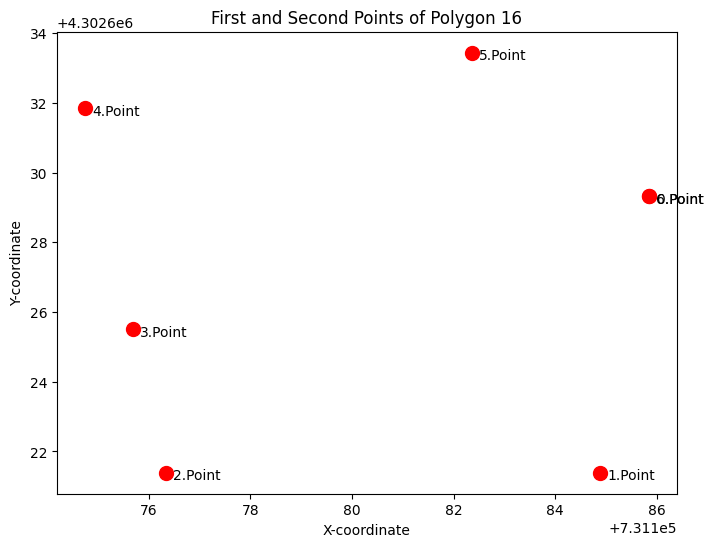

In [10]:
# plot the points of 17. polygon at index 16
shape_file.drop('id', axis=1, inplace=True)
list_16 = list(shape_file.loc[16, "geometry"].exterior.coords)
print(list_16)


# Create a plot
plt.figure(figsize=(8, 6))
for i in range(len(list_16)):
    plt.plot(list_16[i][0], list_16[i][1], 'o', color='red', markersize=10)
    plt.annotate(
        f"{i}." "Point",
        xy=(list_16[i][0], list_16[i][1]),
        xytext=(5, -5),
        textcoords='offset points',
    )
# Add labels and title
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")
plt.title("First and Second Points of Polygon 16")

# Show the plot
plt.show()

In [11]:
import cv2 as cv

# pixel values of png file is 0 or 220
# so we convert it to 0 or 1
# 0 means not tree, 1 means tree
ground_truth = cv.imread("data/SaintLouisTrees/SaintLouisTrees.png", cv.IMREAD_GRAYSCALE)
ret, thresh = cv.threshold(ground_truth, 127, 1, cv.THRESH_BINARY)
print(thresh.shape)


(3001, 3001)


In [12]:
ground_truth_size = ground_truth.shape[0]

In [13]:
def get_row_pixel_index_of_point(point_y):
    pixel_range = (las_max_x - las_min_x) / ground_truth_size
    return int(ground_truth_size - ((point_y - las_min_y) // pixel_range) - 1)

def get_col_pixel_index_of_point(point_x):
    pixel_range = (las_max_y - las_min_y) / ground_truth_size
    return int(ground_truth_size - ((point_x - las_min_x) // pixel_range) - 1)

# Normalize LAS coordinates to match the range of the ground truth image
normalized_x = ((df.X - df.X.min()) / (df.X.max() - df.X.min()) * (ground_truth.shape[1] - 1)) 
normalized_y = ground_truth_size - ((df.Y - df.Y.min()) / (df.Y.max() - df.Y.min()) * (ground_truth.shape[0] - 1)) -1

# Round to the nearest integer to get pixel indices
pixel_indices_x = np.round(normalized_x).astype(int)
pixel_indices_y = np.round(normalized_y).astype(int)

# Map LAS points to ground truth values
df["is_tree"] = thresh[pixel_indices_y, pixel_indices_x]
df.head()

,X,Y,Z,intensity,return_number,number_of_returns,red,green,blue,is_tree
0,911303,275080,160166,12592,2,2,17664,23296,17920,1
1,911981,275055,160212,12944,3,3,15872,22016,15872,1
2,912662,275031,160258,10848,3,3,18432,25344,17408,1
3,913355,275006,160283,8240,3,3,17920,24064,17920,1
4,914036,274981,160313,15968,1,1,17408,22528,18432,1


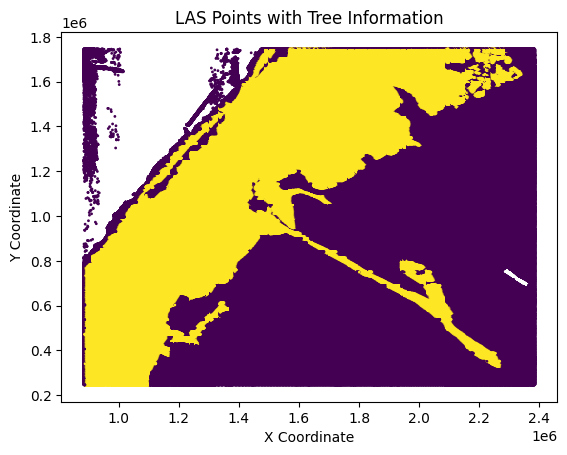

In [14]:
plt.scatter(df.X, df.Y, c=df.is_tree, cmap='viridis', s=1)  # Adjust the colormap as needed
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("LAS Points with Tree Information")
plt.show()

Split data by horizontal line

In [15]:
range_y = las_max_y - las_min_y
limit_y = las_min_y + range_y * 0.5
train_df = df[df["Y"] < limit_y]
test_df = df[df["Y"] >= limit_y]

print(f"train {len(train_df)}, len(test_df)")
print(len(df))


train 5419135, len(test_df)
9236517


In [16]:
train_df.loc[:, ['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']] = StandardScaler().fit_transform(train_df[['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']])
test_df.loc[:, ['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']] = StandardScaler().fit_transform(test_df[['X', 'Y', 'Z', 'intensity', 'red', 'green', 'blue']])
train_df.head()

,X,Y,Z,intensity,return_number,number_of_returns,red,green,blue,is_tree
0,-1.282253,-1.572535,-1.295224,0.147502,2,2,-0.488632,-0.421337,-0.469266,1
1,-1.280819,-1.572651,-1.292033,0.193050,3,3,-0.661024,-0.559393,-0.748021,1
2,-1.279378,-1.572762,-1.288841,-0.078170,3,3,-0.414750,-0.200447,-0.538955,1
3,-1.277912,-1.572878,-1.287107,-0.415642,3,3,-0.464005,-0.338503,-0.469266,1
4,-1.276471,-1.572994,-1.285025,0.584353,1,1,-0.513259,-0.504170,-0.399578,1


In [17]:
x_train = train_df[["X", "Y", "Z", "intensity", "return_number", "number_of_returns", "red", "green", "blue"]]
y_train = train_df["is_tree"]
x_test = test_df[["X", "Y", "Z", "intensity", "return_number", "number_of_returns", "red", "green", "blue"]]
y_test = test_df["is_tree"]

In [18]:
from sklearn.metrics import accuracy_score

K-Neighbors Classifier

In [19]:
# from sklearnex import patch_sklearn
# patch_sklearn()
# from sklearn.neighbors import KNeighborsClassifier
# curr_score = 0

# knn = KNeighborsClassifier(n_neighbors=3001, n_jobs=-1)
# knn.fit(x_train, y_train)
# y_hat = knn.predict(x_test)
# curr_score = accuracy_score(y_test, y_hat)
# print(curr_score)


# 37m 16.5s
# 0.8013261444623566


Random Forest Classifier

In [20]:
# from sklearnex import patch_sklearn
# patch_sklearn()
# from sklearn.ensemble import RandomForestClassifier


# rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
# # rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
# # rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)


# rf_classifier.fit(x_train, y_train)
# y_pred = rf_classifier.predict(x_test)

# accuracy = accuracy_score(y_test, y_pred)
# print("Random Forest Accuracy:", accuracy)


In [21]:
# from sklearn.svm import SVC

# svm = SVC(kernel='rbf')
# svm.fit(x_train, y_train)
# y_hat = svm.predict(x_test)
# print(accuracy_score(y_test, y_hat))

# # Timeout. It worked for 1568 minutes, but we stopped it because it did not produce any results.

Gaussian Naive Bayes Classifier

In [22]:
# from sklearn.naive_bayes import GaussianNB

# # Gaussian Naive Bayes Classifier
# nb_classifier = GaussianNB()
# nb_classifier.fit(x_train, y_train)
# y_pred_nb = nb_classifier.predict(x_test)

# # Calculate accuracy
# accuracy_nb = accuracy_score(y_test, y_pred_nb)
# print("Gaussian Naive Bayes Accuracy:", accuracy_nb)

# #9.3s
# #Gaussian Naive Bayes Accuracy: 0.8417250356396085

Bernoulli Naive Bayes Classifier

In [23]:
from sklearn.naive_bayes import BernoulliNB

# Bernoulli Naive Bayes Classifier
nb_classifier = BernoulliNB()
nb_classifier.fit(x_train, y_train)
y_hat = nb_classifier.predict(x_test)

# Calculate accuracy
accuracy_nb = accuracy_score(y_test, y_hat)
print("Bernoulli Naive Bayes Accuracy:", accuracy_nb)

#4.2s
#Bernoulli Naive Bayes Accuracy: 0.8441636178931006

Bernoulli Naive Bayes Accuracy: 0.8441636178931006


Logistic Regression

In [24]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import GridSearchCV

In [25]:
# # Logistic Regression Classifier with GridSearchCV
# lr_classifier = LogisticRegression()
# parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'max_iter': [100, 200, 300], 'solver': ['liblinear', 'newton-cg', 'lbfgs']}
# grid_search = GridSearchCV(lr_classifier, parameters, cv=5)
# grid_search.fit(x_train, y_train)

# # Best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Predict using the best model
# y_pred_lr = grid_search.predict(x_test)

# # Calculate accuracy
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
# print("Logistic Regression Accuracy:", accuracy_lr)

# # output of the code: 
# # Best Parameters: {'C': 0,001, 'max_iter': 100, 'solver': 'liblinear'}


In [26]:
# # Logistic Regression Classifier with Best Parameters
# lr_classifier = LogisticRegression(C=0.001, max_iter=100, solver='liblinear', class_weight='balanced')
# lr_classifier.fit(x_train, y_train)

# # Predict using the best model
# y_pred_lr = lr_classifier.predict(x_test)

# # Calculate accuracy
# accuracy_lr = accuracy_score(y_test, y_pred_lr)
# print("Logistic Regression Accuracy:", accuracy_lr)

# #Logistic Regression Accuracy: 0.8641582110462092

In [27]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import cross_val_predict

Confusion Matrix:
[[1315401  276098]
 [ 318789 1907094]]


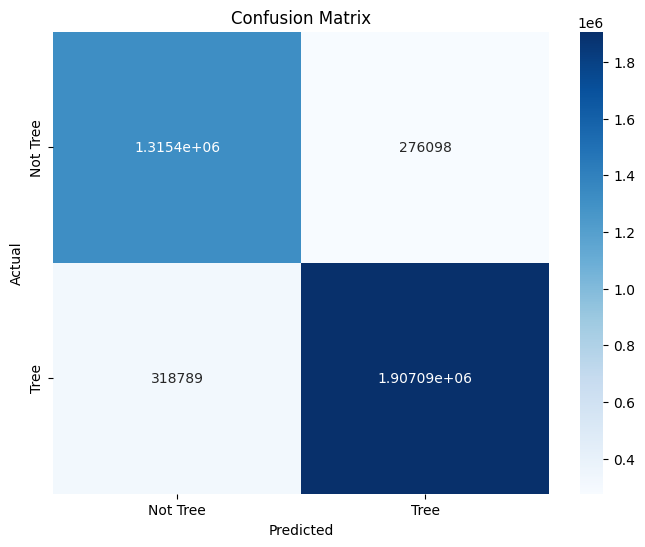

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_hat)
print("Confusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['Not Tree', 'Tree'], yticklabels=['Not Tree', 'Tree'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

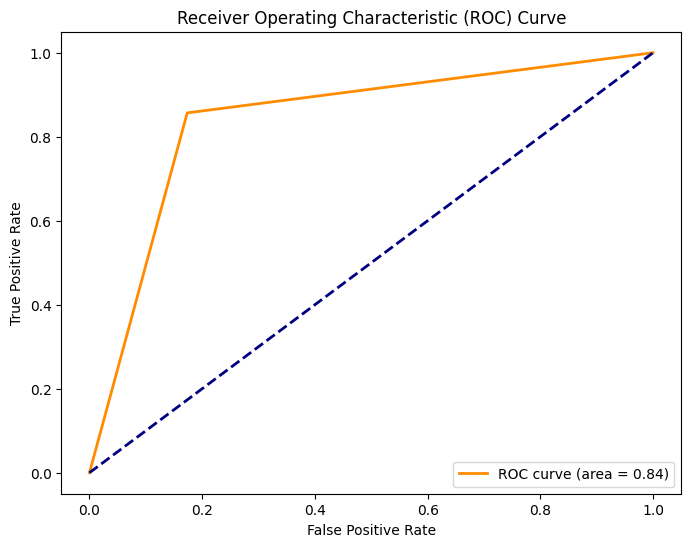

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming y_test and y_pred_nb are already defined

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_hat)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

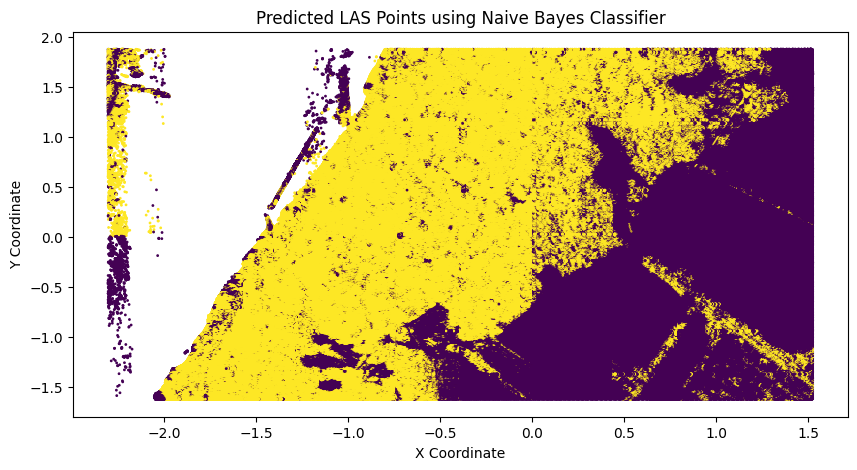

In [30]:
plt.figure(figsize=(10, 5))
plt.scatter(x_test.X, x_test.Y, c=y_hat, cmap='viridis', s=1)  # Adjust the colormap as needed
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Predicted LAS Points using Naive Bayes Classifier")
plt.show()

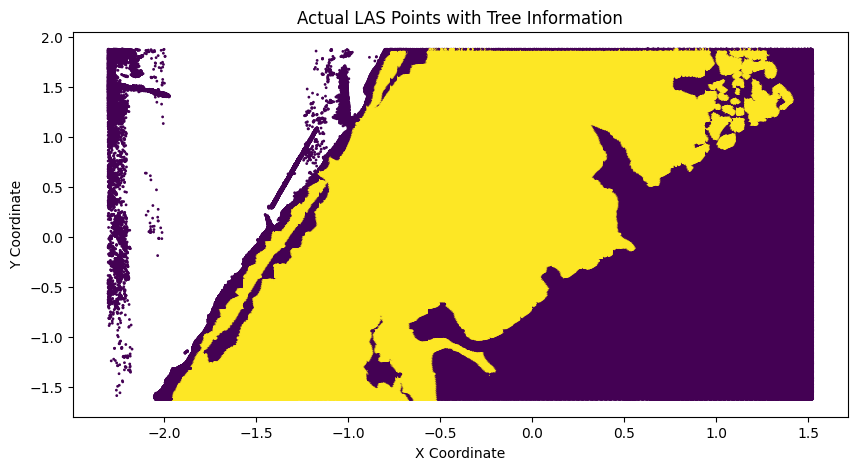

In [31]:
plt.figure(figsize=(10, 5))
plt.scatter(x_test.X, x_test.Y, c=y_test, cmap='viridis', s=1)  # Adjust the colormap as needed
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("Actual LAS Points with Tree Information")
plt.show()

<Axes: >

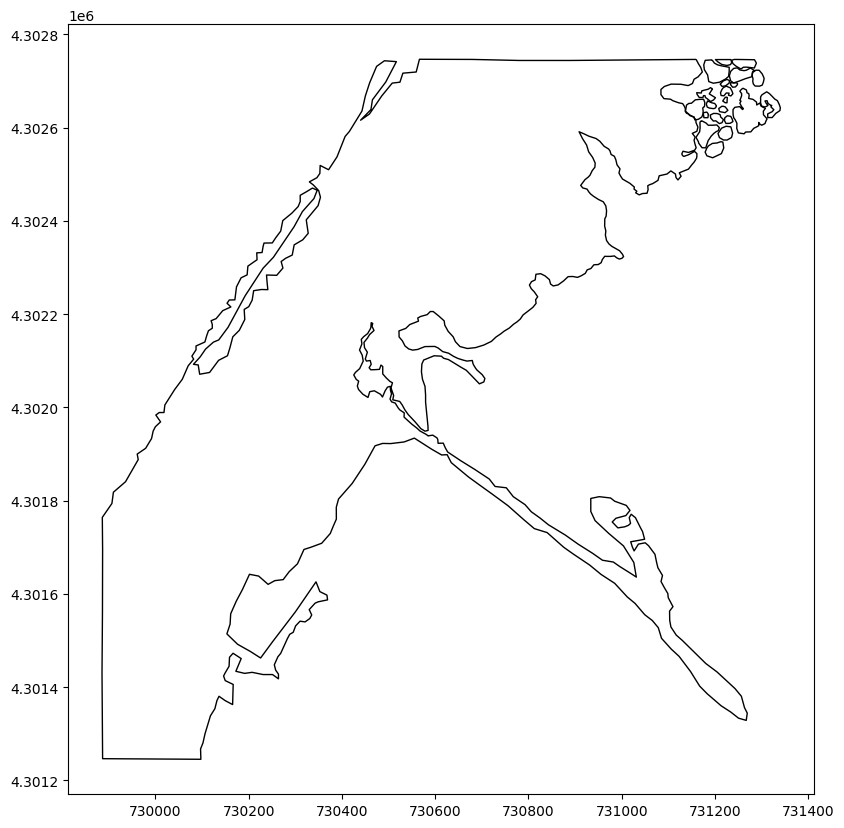

In [32]:
shape_file.plot(figsize=(10,10), edgecolor="k", facecolor="none") # color="green"

In [33]:
# xy_points = gpd.GeoSeries(df.apply(lambda row: Point(row['X'], row['Y']), axis=1))

In [34]:
# def is_inside(points, xp, yp):
#   count = 0
#   for i in range(len(points)-1):
#       (x1,y1) = points[i]
#       (x2,y2) = points[i+1]
#       if (yp < y1) != (yp < y2) and xp <= x1 + ((abs(yp - y1)) / (abs(y2 - y1))) * abs((x2 - x1)):
#           count += 1
#   return count%2 == 1

In [35]:

# df["is_tree"] = False
# for i in range(len_data):
#     for poly in shape_file['geometry']:
#         if xy_points[i].within(poly):
#             df.at[i, "is_tree"] = True
#             break  # Bir polygon içinde olduğunda döngüden çık
        
# df['is_tree'] = df["is_tree"].astype('int32')

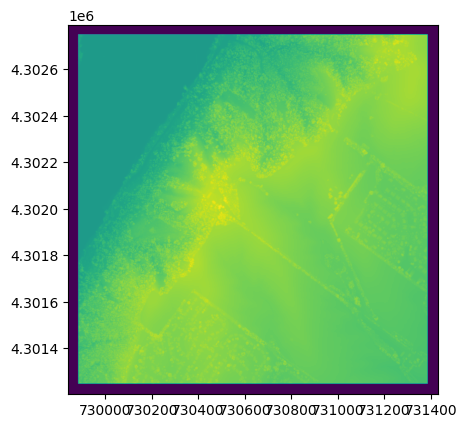

3175 3176
<class 'rasterio.io.DatasetReader'>
BoundingBox(left=729840.9373750874, bottom=4301202.786778949, right=731428.4373750874, top=4302790.786778949)
| 0.50, 0.00, 729840.94|
| 0.00,-0.50, 4302790.79|
| 0.00, 0.00, 1.00|
(729840.9373750874, 4302790.786778949)
(731428.4373750874, 4301202.786778949)
(3176, 3175)
0.0


In [36]:

tif_file = rasterio.open("data/SaintLouisDSM/SaintLouisDSM.tif")
show(tif_file)
full_image = tif_file.read()
print(tif_file.width, tif_file.height)
print(type(tif_file))
print(tif_file.bounds)
print(tif_file.transform)
print(tif_file.transform * (0,0))
print(tif_file.transform * (tif_file.width, tif_file.height))
print(tif_file.read(1).shape) # returns numpy array
print(tif_file.read(1)[0,0])

In [37]:
print(full_image.shape)
num_bands = tif_file.count
print("Number of bands in the image ",num_bands)

(1, 3176, 3175)
Number of bands in the image  1


In [38]:
img_band1 = tif_file.read(1)
img_band1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [39]:
print("Coordinate Reference System ",tif_file.crs)

Coordinate Reference System  EPSG:32615


In [40]:
metadata = tif_file.meta
print("Metadata: ",metadata)

Metadata:  {'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 3175, 'height': 3176, 'count': 1, 'crs': CRS.from_epsg(32615), 'transform': Affine(0.5, 0.0, 729840.9373750874,
       0.0, -0.5, 4302790.786778949)}


In [41]:

description = tif_file.descriptions
print("Description: ",description)

Description:  (None,)


In [42]:
print("Geotransform: ",tif_file.transform)

Geotransform:  | 0.50, 0.00, 729840.94|
| 0.00,-0.50, 4302790.79|
| 0.00, 0.00, 1.00|


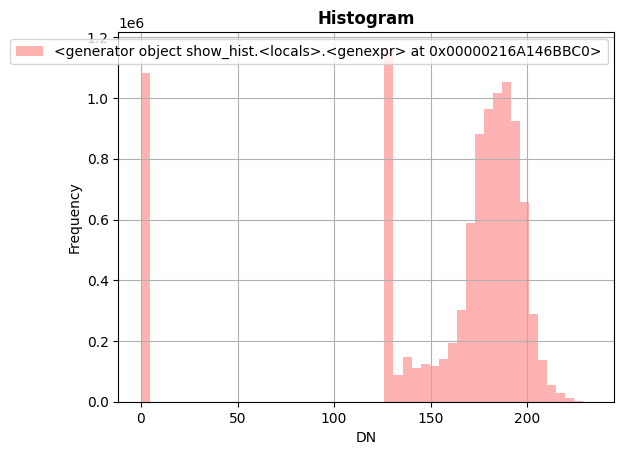

In [43]:
rasterio.plot.show_hist(tif_file, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

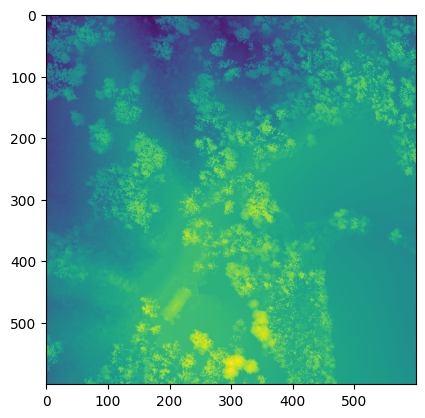

In [44]:
clipped_img = full_image[:, 1000:1600, 1000:1600]
plt.imshow(clipped_img[0,:,:])


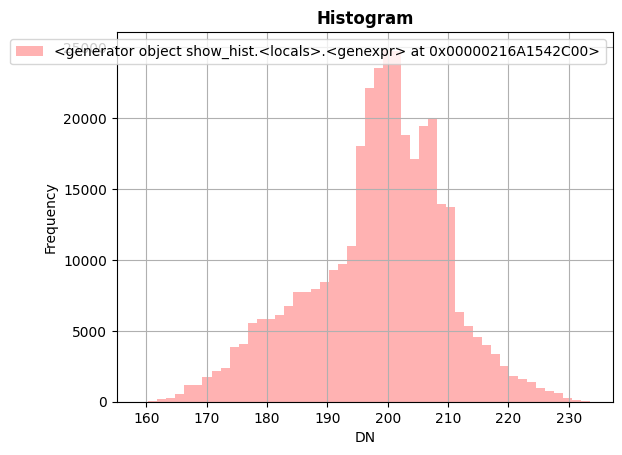

In [45]:
rasterio.plot.show_hist(clipped_img, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram")

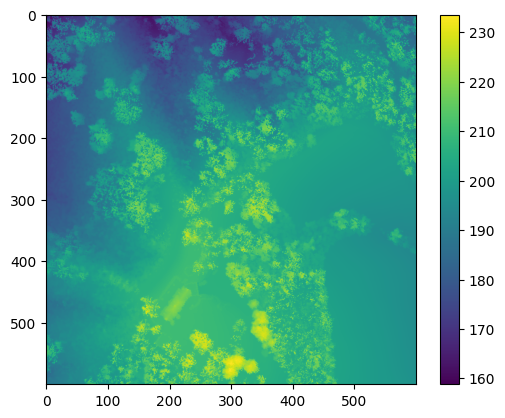

In [46]:
red_clipped = clipped_img[0].astype('f4')
plt.imshow(red_clipped)
plt.colorbar()